In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.sparse import bmat, coo_matrix, diags, eye
from scipy.sparse.linalg import spsolve
from itertools import product

In [136]:
# Define parameters
Ds, Dc = 10, 1
kf, gam = 5, 1
lam = 0
N = 100
L = 5

z = np.linspace(0, L, num=N+1)
x = np.linspace(0, L, num=N+1)
h = x[1] - x[0]

In [137]:
# Set up matrix and vector

submatrices = [[None]*N for _ in range(N)]
rhs = [None]*N

## Construct the first block row
submatrices[0][0] = -eye(N, format='coo')
submatrices[0][1] = diags(np.ones(N-1), offsets=-1, shape=(N, N-1), format='coo')

## Construct the rest of the block matrix
for i in range(1, N):
    M = N - 1 - i
    diagonal = np.ones(N-i)
    diagonal[-1] = 0
    ### Construct the block subdiagonal
    submatrices[i][i-1] = (Ds/h**2 + kf/(2*h*gam)*(z[i] - lam))*diags(
        diagonal, offsets=1, shape=(N-i, N-i+1), format='coo')
    ### Construct the block diagonal
    part1 = diags(diagonal, offsets=0, shape=(N-i, N-i))
    if i < N - 1:
        part2 = coo_matrix(([1, -1], ([N-i-1, N-i-1], [N-i-2, N-i-1])), shape=(N-i, N-i))
    elif i == N - 1:
        part2 = coo_matrix(([-1], ([0], [0])), shape=(1,1))
    part3 = diags([diagonal[1:], diagonal[:-1]], offsets=[-1, 1], 
                  shape=(N-i, N-i), format='coo')
    submatrices[i][i] = -2*(Dc+Ds)/h**2*part1 + part2 + Dc/h**2*part3
    ### Construct the block superdiagonal
    if i < N - 1:
        submatrices[i][i+1] = (Ds/h**2 - kf/(2*h*gam)*(z[i] - lam))*diags(
            diagonal[1:], offsets=-1, shape=(N-i, N-i-1), format='coo')

## Construct a single matrix from the array of submatrices
A = bmat(submatrices, format='csr')
# print(A.toarray()) #Diagonal is correct, the superdiagonal was wrong
## Construct the rhs vector
rhs = np.zeros(N)
temp = -np.ones(N)
temp[-1] = 0
for i in range(1, N):
    rhs = np.append(rhs, temp[i:])
# print(rhs) #This is correct
## Solve the system
sol = spsolve(A, rhs)

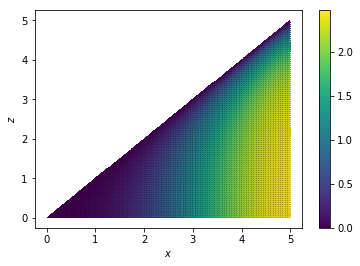

In [141]:
xtri = []
for i in range(N+1):
    xtri.append(x[i:])
xtri = np.hstack(xtri)
ztri = np.repeat(z, np.arange(1, N+2)[::-1])
npoints = xtri.shape[0]

trirows = []
for i in range(N+1, 1, -1):
    ti = i*(i+1)/2
    offset = npoints - ti
    for j in range(0, i-1):
        trirows.append(np.array([offset + j, offset + j + 1, offset + j + i]))
    if i > 2:
        for j in range(1, i-1):
            trirows.append(np.array([offset + j, offset + j + i, offset + j + i - 1]))
tri = np.vstack(trirows)

obj = []
tn = N*(N+1)/2
for i in range(N, 0, -1):
    obj.append(tn - i*(i+1)/2)
plot_sol = np.insert(sol, obj=np.array(obj), values=0)
plot_sol = np.append(plot_sol, 0)

triangulation = Triangulation(xtri, ztri, tri)
plt.triplot(triangulation, 'k-', linewidth=0.1)
plt.tripcolor(triangulation, plot_sol, shading='flat')
plt.xlabel('$x$')
plt.ylabel('$z$')
plt.colorbar()
plt.show()

In [23]:
# Does this make any sense?

In [24]:
print(plot_sol.shape)
print(xtri.shape)

(66,)
(66,)


In [25]:
print(xtri)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.   1.   2.   3.   4.
   5.   6.   7.   8.   9.  10.   2.   3.   4.   5.   6.   7.   8.   9.  10.
   3.   4.   5.   6.   7.   8.   9.  10.   4.   5.   6.   7.   8.   9.  10.
   5.   6.   7.   8.   9.  10.   6.   7.   8.   9.  10.   7.   8.   9.  10.
   8.   9.  10.   9.  10.  10.]


In [26]:
print(plot_sol)

[ 0.         -0.          1.16269373  1.75442138  2.04132898  2.17299973
  2.22974497  2.25246029  2.26065964  2.26300231  2.26300231  0.
  1.16269373  1.75442138  2.04132898  2.17299973  2.22974497  2.25246029
  2.26065964  2.26300231  2.26300231  0.          0.87667112  1.29096807
  1.47815355  1.55628339  1.58576493  1.59547093  1.59789742  1.59789742
  0.          0.6078582   0.90452381  1.03268137  1.08060755  1.0956527
  1.09911067  1.09911067  0.          0.46895721  0.68665298  0.76949433
  0.79479143  0.80025121  0.80025121  0.          0.36456656  0.51361392
  0.55904682  0.56835763  0.56835763  0.          0.27846622  0.3671668
  0.38468654  0.38468654  0.          0.19348148  0.23090202  0.23090202
  0.          0.10243131  0.10243131  0.          0.          0.        ]
